# tree_baseline

> Simple tree baseline

In [ ]:
try: import kaggle_hct_survival
except:
    !pip install git+https://github.com/ozpau/kaggle_hct_survival.git

In [ ]:
#| default_exp tree_baseline

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
from fastcore.all import *
from oztools.kgl import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from fastai.tabular.all import *
from fastbook import *
import warnings

In [ ]:
#| export
path = setup_comp(
    'equity-post-HCT-survival-predictions',
    'git+https://github.com/ozpau/kaggle_hct_survival.git'
)
Path.BASE_PATH = path
path.ls()

(#4) [Path('test.csv'),Path('data_dictionary.csv'),Path('sample_submission.csv'),Path('train.csv')]

In [ ]:
train = pd.read_csv(path/"train.csv", index_col=0)
test = pd.read_csv(path/"test.csv", index_col=0)
desc = pd.read_csv(path/"data_dictionary.csv", index_col=0).T
sample_sub = pd.read_csv(path/"sample_submission.csv", index_col=0)

train.shape, test.shape

((28800, 59), (3, 57))

It appears that there are `58` columns in the testing data. One of them is the target variable, but what is the other one?

In [ ]:
ys = train.columns.difference(test.columns)
ys

Index(['efs', 'efs_time'], dtype='object')

What are these columns for?

In [ ]:
desc[ys].T

,description,type,values
variable,,,
efs,Event-free survival,Categorical,['Event' 'Censoring']
efs_time,"Time to event-free survival, months",Numerical,NaN


In [ ]:
dep_vars = ["efs", "efs_time"]

In [ ]:
sample_sub.columns

Index(['prediction'], dtype='object')

From the dataset description:
> The primary outcome of interest is event-free survival, represented by the variable efs, while the time to event-free survival is captured by the variable efs_time. These two variables together encode the target for a censored time-to-event analysis.

https://www.cancer.gov/publications/dictionaries/cancer-terms/def/event-free-survival

### event-free survival
> In cancer, the length of time after primary treatment for a cancer ends that the patient remains free of certain complications or events that the treatment was intended to prevent or delay. These events may include the return of the cancer or the onset of certain symptoms, such as bone pain from cancer that has spread to the bone. In a clinical trial, measuring the event-free survival is one way to see how well a new treatment works. Also called EFS.

So, here's a picture: we have a treatment and we observe a population of patients.

For some of the patients, they live normally, but others face events.
When a patient faces an event, we can record the time between treatment and event.

But for patients that haven't experienced event, we can't compute the time between treatment and event.
I suppose there could be two cases.
One is that the patient is still alive and haven't experienced an event.
And another is that the patient is deceased but for an unrelated cause (for example, a car accident).

So, what we want to know is would we be able to observe an event or not? In other words, would the treatment benefit the patient?

Naturally, for testing dataset, if treatment has been administered recently, it is reasonable to expect that we shouldn't have had
observed any events yet. So I suspect that the testing dataset consists of patients with treatment dates sampled uniformly across all available treatment dates.

In [ ]:
time_vars = ['year_hct', 'donor_age', 'age_at_hct']
train[time_vars].describe()

,year_hct,donor_age,age_at_hct
count,28800.000000,26992.000000,28800.000000
mean,2015.179444,42.511591,38.663162
std,3.153914,15.251434,21.147581
min,2008.000000,18.010000,0.044000
25%,2013.000000,28.447000,19.539000
50%,2016.000000,40.063000,41.006000
75%,2018.000000,56.131500,55.965250
max,2020.000000,84.800000,73.726000


In [ ]:
test[time_vars]

,year_hct,donor_age,age_at_hct
ID,,,
28800,2016,NaN,9.942
28801,2008,72.29,43.705
28802,2019,NaN,33.997


## Preprocess the data

Let's join testing and training data for convenience into one dataframe and let's also preprocess categorical
and missing data

In [ ]:
pvalid = 0.2
#train.loc[len(train)

## Understanding outcomes

In [ ]:
sample_sub.head().T

ID,28800,28801,28802
prediction,0.5,0.5,0.5


In [ ]:
vars_submit = ["efs"]
train[vars_submit].sample(5).T

ID,18932,21280,27880,15692,25416
efs,0.0,1.0,1.0,1.0,1.0


In [ ]:
train[vars_submit].value_counts()

efs
1.0    15532
0.0    13268
Name: count, dtype: int64

Makes sense. A person either survives or not.

But there is also time to survival. Is there some masking envolved?

<matplotlib.legend.Legend>

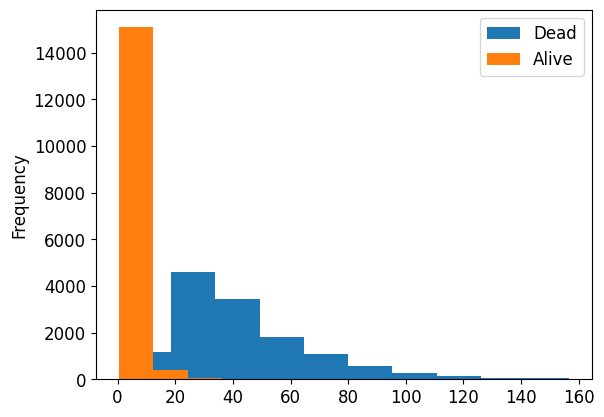

In [ ]:
train.query('efs == 0')['efs_time'].plot.hist(label="Dead")
train.query('efs == 1')['efs_time'].plot.hist(label="Alive")
plt.legend()

## Validation set
Lets select validation set and join all data into one dataframe for ease of use.

But first, we need to understand what kind of sampling differences are to expect from
the testing dataset.
- Is it going to be sampled from the same prior distribution as the testing set?
- Is it going to be sampled for future patients?
- Is 

## Scratch Work

In [ ]:
train_conds = np.arange(len(train)) < len(train)*0.8

train_idx = np.where( train_conds)[0]
valid_idx = np.where(~train_conds)[0]
splits = (list(train_idx), list(valid_idx))

procs = [Categorify, FillMissing]
cont,cat = cont_cat_split(train, 40, dep_var=dep_vars)

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    # debug
    to = TabularPandas(train, procs, cat, cont, y_names=dep_vars, splits=splits)
    #to = TabularPandas(train.drop(, procs, cat, cont, y_names=dep_vars, splits=splits)

In [ ]:
def preprocess_test_data(to):
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        dls = to.dataloaders()
        dl = dls.test_dl(test)
        return dl.dataset.items

In [ ]:
processed_test = preprocess_test_data(to)

In [ ]:
'efs' in processed_test or 'efs_time' in processed_test

False

In [ ]:
'efs_time' in processed_test.columns

False

In [ ]:
list(zip(to.items.drop(columns=['efs','efs_time']).columns, processed_test.columns))

[('dri_score', 'dri_score'),
 ('psych_disturb', 'psych_disturb'),
 ('cyto_score', 'cyto_score'),
 ('diabetes', 'diabetes'),
 ('hla_match_c_high', 'hla_match_c_high'),
 ('hla_high_res_8', 'hla_high_res_8'),
 ('tbi_status', 'tbi_status'),
 ('arrhythmia', 'arrhythmia'),
 ('hla_low_res_6', 'hla_low_res_6'),
 ('graft_type', 'graft_type'),
 ('vent_hist', 'vent_hist'),
 ('renal_issue', 'renal_issue'),
 ('pulm_severe', 'pulm_severe'),
 ('prim_disease_hct', 'prim_disease_hct'),
 ('hla_high_res_6', 'hla_high_res_6'),
 ('cmv_status', 'cmv_status'),
 ('hla_high_res_10', 'hla_high_res_10'),
 ('hla_match_dqb1_high', 'hla_match_dqb1_high'),
 ('tce_imm_match', 'tce_imm_match'),
 ('hla_nmdp_6', 'hla_nmdp_6'),
 ('hla_match_c_low', 'hla_match_c_low'),
 ('rituximab', 'rituximab'),
 ('hla_match_drb1_low', 'hla_match_drb1_low'),
 ('hla_match_dqb1_low', 'hla_match_dqb1_low'),
 ('prod_type', 'prod_type'),
 ('cyto_score_detail', 'cyto_score_detail'),
 ('conditioning_intensity', 'conditioning_intensity'),
 ('et

In [ ]:
processed_test.columns

Index(['dri_score', 'psych_disturb', 'cyto_score', 'diabetes',
       'hla_match_c_high', 'hla_high_res_8', 'tbi_status', 'arrhythmia',
       'hla_low_res_6', 'graft_type', 'vent_hist', 'renal_issue',
       'pulm_severe', 'prim_disease_hct', 'hla_high_res_6', 'cmv_status',
       'hla_high_res_10', 'hla_match_dqb1_high', 'tce_imm_match', 'hla_nmdp_6',
       'hla_match_c_low', 'rituximab', 'hla_match_drb1_low',
       'hla_match_dqb1_low', 'prod_type', 'cyto_score_detail',
       'conditioning_intensity', 'ethnicity', 'year_hct', 'obesity', 'mrd_hct',
       'in_vivo_tcd', 'tce_match', 'hla_match_a_high', 'hepatic_severe',
       'donor_age', 'prior_tumor', 'hla_match_b_low', 'peptic_ulcer',
       'age_at_hct', 'hla_match_a_low', 'gvhd_proph', 'rheum_issue',
       'sex_match', 'hla_match_b_high', 'race_group', 'comorbidity_score',
       'karnofsky_score', 'hepatic_mild', 'tce_div_match', 'donor_related',
       'melphalan_dose', 'hla_low_res_8', 'cardiac', 'hla_match_drb1_high',
 

In [ ]:
pd.concat([train,test]).shape, train.shape, test.shape

((28803, 59), (28800, 59), (3, 57))

def fill_test():
    train_conds = np.arange(len(train) + len(test)) < len(train)
    
    train_idx = np.where( train_conds)[0]
    valid_idx = np.where(~train_conds)[0]
    splits = (list(train_idx), list(valid_idx))
    
    df = pd.concat([train,test]).copy()
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        to = TabularPandas(df, procs, cat, cont);
    return to.items.iloc[len(train):].drop(columns=['efs', 'efs_time'])

fill_test()

In [ ]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

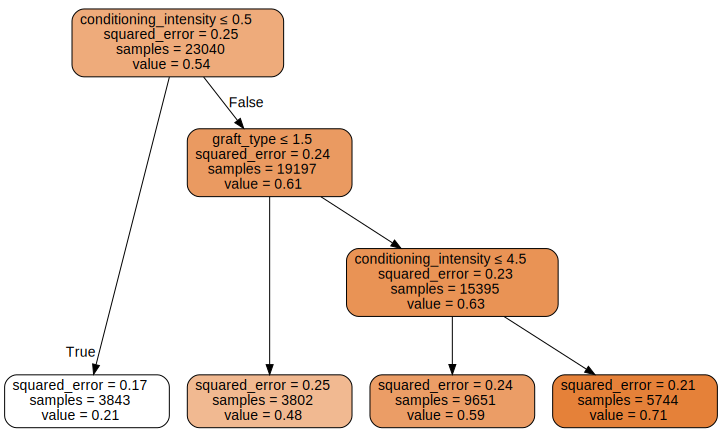

In [ ]:
m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(xs, y);

draw_tree(m, xs, size=10, leaves_parallel=True, precision=2)

In [ ]:
desc['conditioning_intensity']

description                                                Computed planned conditioning intensity
type                                                                                   Categorical
values         ['RIC' nan 'NMA' 'MAC' 'TBD' 'No drugs reported'\n 'N/A, F(pre-TED) not submitted']
Name: conditioning_intensity, dtype: object

In [ ]:
to.classes['conditioning_intensity']

['#na#', 'MAC', 'N/A, F(pre-TED) not submitted', 'NMA', 'No drugs reported', 'RIC', 'TBD']

In [ ]:
to.classes['graft_type']

['#na#', 'Bone marrow', 'Peripheral blood']

In [ ]:
len(preprocess_test_data(to).columns), len(m.feature_names_in_)

(77, 77)

In [ ]:
df = preprocess_test_data(to)
df.reindex(columns = m.feature_names_in_)

,dri_score,psych_disturb,cyto_score,diabetes,tbi_status,arrhythmia,graft_type,vent_hist,renal_issue,pulm_severe,prim_disease_hct,cmv_status,tce_imm_match,rituximab,prod_type,cyto_score_detail,conditioning_intensity,ethnicity,year_hct,obesity,mrd_hct,in_vivo_tcd,tce_match,hepatic_severe,prior_tumor,peptic_ulcer,gvhd_proph,rheum_issue,sex_match,race_group,hepatic_mild,tce_div_match,donor_related,melphalan_dose,cardiac,pulm_moderate,hla_match_c_high_na,hla_high_res_8_na,hla_low_res_6_na,hla_high_res_6_na,hla_high_res_10_na,hla_match_dqb1_high_na,hla_nmdp_6_na,hla_match_c_low_na,hla_match_drb1_low_na,hla_match_dqb1_low_na,hla_match_a_high_na,donor_age_na,hla_match_b_low_na,hla_match_a_low_na,hla_match_b_high_na,comorbidity_score_na,karnofsky_score_na,hla_low_res_8_na,hla_match_drb1_high_na,hla_low_res_10_na,hla_match_c_high,hla_high_res_8,hla_low_res_6,hla_high_res_6,hla_high_res_10,hla_match_dqb1_high,hla_nmdp_6,hla_match_c_low,hla_match_drb1_low,hla_match_dqb1_low,hla_match_a_high,donor_age,hla_match_b_low,age_at_hct,hla_match_a_low,hla_match_b_high,comorbidity_score,karnofsky_score,hla_low_res_8,hla_match_drb1_high,hla_low_res_10
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
28800,8,1,0,1,1,1,1,1,1,1,7,1,0,1,1,0,0,3,9,1,0,2,0,1,1,1,12,1,3,4,1,0,3,2,1,1,2,2,1,1,2,1,1,1,1,1,1,2,1,1,1,1,1,1,1,1,2.0,8.0,6.0,6.0,10.0,2.0,6.0,2.0,2.0,2.0,2.0,40.153999,2.0,9.942,2.0,2.0,0.0,90.0,8.0,2.0,10.0
28801,3,1,2,1,7,1,2,1,1,1,3,1,8,1,2,2,1,3,1,1,2,1,4,1,1,1,14,1,1,2,1,4,2,2,1,3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2.0,8.0,6.0,6.0,10.0,2.0,6.0,2.0,2.0,2.0,2.0,72.290000,2.0,43.705,2.0,2.0,3.0,90.0,8.0,2.0,10.0
28802,8,1,0,1,1,1,1,1,1,1,6,1,8,1,1,0,0,3,12,1,0,2,0,1,1,1,8,1,2,4,1,4,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,2,1,1,1,1,1,1,1,1,2.0,8.0,6.0,6.0,10.0,2.0,6.0,2.0,2.0,2.0,2.0,40.153999,2.0,33.997,2.0,2.0,0.0,90.0,8.0,2.0,10.0


In [ ]:
list(zip(preprocess_test_data(to).reindex(columns = m.feature_names_in_).columns, m.feature_names_in_))

[('dri_score', 'dri_score'),
 ('psych_disturb', 'psych_disturb'),
 ('cyto_score', 'cyto_score'),
 ('diabetes', 'diabetes'),
 ('tbi_status', 'tbi_status'),
 ('arrhythmia', 'arrhythmia'),
 ('graft_type', 'graft_type'),
 ('vent_hist', 'vent_hist'),
 ('renal_issue', 'renal_issue'),
 ('pulm_severe', 'pulm_severe'),
 ('prim_disease_hct', 'prim_disease_hct'),
 ('cmv_status', 'cmv_status'),
 ('tce_imm_match', 'tce_imm_match'),
 ('rituximab', 'rituximab'),
 ('prod_type', 'prod_type'),
 ('cyto_score_detail', 'cyto_score_detail'),
 ('conditioning_intensity', 'conditioning_intensity'),
 ('ethnicity', 'ethnicity'),
 ('year_hct', 'year_hct'),
 ('obesity', 'obesity'),
 ('mrd_hct', 'mrd_hct'),
 ('in_vivo_tcd', 'in_vivo_tcd'),
 ('tce_match', 'tce_match'),
 ('hepatic_severe', 'hepatic_severe'),
 ('prior_tumor', 'prior_tumor'),
 ('peptic_ulcer', 'peptic_ulcer'),
 ('gvhd_proph', 'gvhd_proph'),
 ('rheum_issue', 'rheum_issue'),
 ('sex_match', 'sex_match'),
 ('race_group', 'race_group'),
 ('hepatic_mild', 'h

In [ ]:
def predict(to):
    df = preprocess_test_data(to).reindex(columns = m.feature_names_in_)
    df = pd.DataFrame({"prediction": m.predict(df)}, index=df.index)
    df.index.name = "ID"
    return df

In [ ]:
df = predict(to)
df.to_csv("var/submission.csv")

In [ ]:
!head {path}/sample_submission.csv

ID,prediction
28800,0.5
28801,0.5
28802,0.5


In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()